# Data Pipeline

**Contents**
1. Load simulated datasets from `/data`.
2. Apply initial filtering by doing hard cuts by doing Manual filtering/ hard cuts. This will be done on all the datasets, including the simulated acceptance.
3. Train Machine Learning model(s) on the partially filtered datasets
4. Classify and filter the `total_dataset` and `acceptance_mc` based on predictions from the model
5. Off to Fitting group!

---

# 1. Load Data

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pickle
%config InlineBackend.figure_formats = ['svg']

Load total and acceptance datasets

In [2]:
total = pd.read_pickle('data/total_dataset.pkl')
acc = pd.read_pickle('data/acceptance_mc.pkl')

Load simulated datasets and append to one another to create long dataframe with class label. In this case we are doing **binary classification** so the two classes are `signal` and `other`.

In [3]:
simulations = ['jpsi_mu_k_swap','psi2S','jpsi_mu_pi_swap', 'phimumu', 'pKmumu_piTop',
    'signal','pKmumu_piTok_kTop','k_pi_swap','jpsi']

df = pd.DataFrame()

for file in simulations:
    temp_df = pd.read_pickle('data/' + file + '.pkl')
    if file == 'signal': 
        temp_df["class"] = 'signal'
    else:
        temp_df["class"] = 'other'
    df = df.append(temp_df, ignore_index=True)

sim = df


# 2. Manual Cuts

In [4]:
%%capture
from Filter_plots import q2_cuts, IP_check, mom_check, muon_PT_check, invariant_mass_check, particle_ID_check, check_all

## Cut on the total dataset, acceptance and simulated

In [5]:
cuts = [q2_cuts, particle_ID_check]

def apply_cuts(df, cuts, verbose= False):
    for cut in cuts:
        df = cut(df)
        if verbose:
            print(df['class'].value_counts()/len(df))
    print('---')
    return df

# Cutting based on all the cuts
print('Total Dataset')
total = apply_cuts(total, cuts)
print('Acceptance')
acc = apply_cuts(acc, cuts)
print('Simulated Dataset')
sim = apply_cuts(sim, cuts, True)

#total = q2_cuts(total)
#acc = q2_cuts(acc)
#sim = q2_cuts(sim)

Total Dataset
percentage dataframe removed = 0.8972553663358388
percentage dataframe removed = 0.9096147835599312
---
Acceptance
percentage dataframe removed = 0.3394530863112551
percentage dataframe removed = 0.17915226210563884
---
Simulated Dataset
percentage dataframe removed = 0.799171778969561
signal    0.550193
other     0.449807
Name: class, dtype: float64
percentage dataframe removed = 0.5408190969466605
signal    0.98446
other     0.01554
Name: class, dtype: float64
---


In [6]:
len(total), len(acc), len(sim)

(4627, 388687, 131919)

# 3. Machine Learning

Here a Machine Learning model is trained with features in `cols_to_use`, which excludes meaningless columns such as `year`.

Also, we shouldn't cut based on the models we are trying to fit on, namely `phi`, `'costhetal'` and `'costhetak'`.

In [7]:
features = ['mu_plus_MC15TuneV1_ProbNNk', 'mu_plus_MC15TuneV1_ProbNNpi',
       'mu_plus_MC15TuneV1_ProbNNmu', 'mu_plus_MC15TuneV1_ProbNNe',
       'mu_plus_MC15TuneV1_ProbNNp', 'mu_plus_P', 'mu_plus_PT', 'mu_plus_ETA',
       'mu_plus_PHI', 'mu_plus_PE', 'mu_plus_PX', 'mu_plus_PY', 'mu_plus_PZ',
       'mu_plus_IPCHI2_OWNPV', 
       'mu_minus_MC15TuneV1_ProbNNk', 'mu_minus_MC15TuneV1_ProbNNpi', 'mu_minus_MC15TuneV1_ProbNNmu',
       'mu_minus_MC15TuneV1_ProbNNe', 'mu_minus_MC15TuneV1_ProbNNp',
       'mu_minus_P', 'mu_minus_PT', 'mu_minus_ETA', 'mu_minus_PHI',
       'mu_minus_PE', 'mu_minus_PX', 'mu_minus_PY', 'mu_minus_PZ',
       'mu_minus_IPCHI2_OWNPV', 
       'K_MC15TuneV1_ProbNNk', 'K_MC15TuneV1_ProbNNpi', 'K_MC15TuneV1_ProbNNmu',
       'K_MC15TuneV1_ProbNNe', 'K_MC15TuneV1_ProbNNp', 'K_P', 'K_PT', 'K_ETA',
       'K_PHI', 'K_PE', 'K_PX', 'K_PY', 'K_PZ', 'K_IPCHI2_OWNPV',
       'Pi_MC15TuneV1_ProbNNk', 'Pi_MC15TuneV1_ProbNNpi',
       'Pi_MC15TuneV1_ProbNNmu', 'Pi_MC15TuneV1_ProbNNe',
       'Pi_MC15TuneV1_ProbNNp', 'Pi_P', 'Pi_PT', 'Pi_ETA', 'Pi_PHI', 'Pi_PE',
       'Pi_PX', 'Pi_PY', 'Pi_PZ', 'Pi_IPCHI2_OWNPV', 
       'B0_MM', 'B0_ENDVERTEX_CHI2', 'B0_ENDVERTEX_NDOF', 'B0_FDCHI2_OWNPV', 
       'Kstar_MM', 'Kstar_ENDVERTEX_CHI2', 'Kstar_ENDVERTEX_NDOF', 'Kstar_FDCHI2_OWNPV',
       'J_psi_MM', 'J_psi_ENDVERTEX_CHI2', 'J_psi_ENDVERTEX_NDOF',
       'J_psi_FDCHI2_OWNPV', 
       'B0_IPCHI2_OWNPV', 'B0_DIRA_OWNPV', 'B0_OWNPV_X',
       'B0_OWNPV_Y', 'B0_OWNPV_Z', 'B0_FD_OWNPV', 'B0_ID', 'q2']

In [8]:
# Import machine learning models
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

How many of the other classes are left?

In [9]:
plt.figure(figsize=(6,4))
sim['class'].value_counts()

signal    129869
other       2050
Name: class, dtype: int64

<Figure size 432x288 with 0 Axes>

## 3.1 Training and Hyperparameter tuning

We want to optimise the models for negative predictive value.

In [10]:
# Feature dataset
X = sim[features]
# Labels/ class dataset
y = sim.iloc[:, -1]

# Test train split, in a stratified manner
X_train, X_valid, y_train, y_valid = train_test_split(X, y, random_state=20, stratify = y)


## 3.2 Validation

In [12]:
forest = RandomForestClassifier(verbose=1, n_jobs = 4)
forest.fit(X_train, y_train)
#pickle.dump(forest, open('saved_models/02_22rf.pkl', 'wb'))

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    9.5s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:   21.9s finished


RandomForestClassifier(n_jobs=4, verbose=1)

In [125]:
y_valid_pred = forest.predict(X_valid)

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished


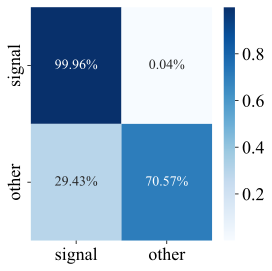

In [126]:
from sklearn.metrics import confusion_matrix 
cm_forest = confusion_matrix(y_valid, y_valid_pred, labels = ['signal', 'other'])

plt.figure(figsize=(4,4))
sns.heatmap(cm_forest/cm_forest.sum(keepdims=True, axis=1), annot=True, 
            fmt='.2%', cmap='Blues', xticklabels=['signal', 'other'], yticklabels=['signal', 'other'])

plt.tight_layout()

## 3. Optimising Decision Thresholds
Since our data is heavily skewed, we should consider precision and recall rather than metrics such as accuracy, true positive rate (TPR) or true negative rate (TNR).

Precision is defined as 

$$\text{Prec} = \frac{\text{TP} }{\text{TP} + \text{FP}}$$

whilst Recall is 

$$\text{Rec} = \frac{\text{TP} }{\text{TP} + \text{FN}}$$

This is helpful as we want to reduce the number of false positives (i.e. non-signal classified as signal).

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished


Text(0, 0.5, 'Precision')

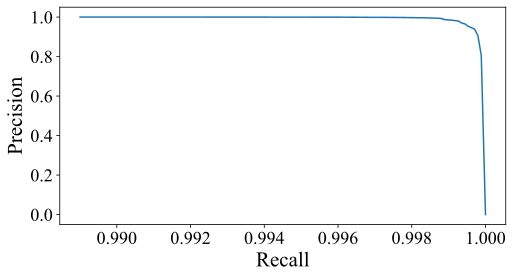

In [30]:
from sklearn.metrics import precision_recall_curve

y_score = forest.predict_proba(X_valid)[:,1]

p, r, thresholds = precision_recall_curve(y_valid, y_score, pos_label='signal' )

plt.figure(figsize=(8,4))
plt.plot(p,r)
plt.xlabel('Recall')
plt.ylabel('Precision')


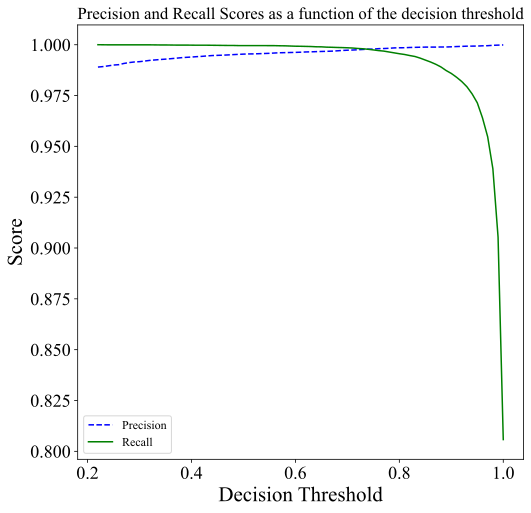

In [24]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    """
    Modified from:
    Hands-On Machine learning with Scikit-Learn
    and TensorFlow; p.89
    """
    plt.figure(figsize=(8, 8))
    plt.title("Precision and Recall Scores as a function of the decision threshold")
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
    plt.ylabel("Score")
    plt.xlabel("Decision Threshold")
    plt.legend(loc='best')

plot_precision_recall_vs_threshold(p,r,thresholds)


# 4. Classification

In [127]:
def gen_predictions(df, cols_to_use, model):
    """Drops rows based on its class, which is inferred 
    by Classifying through a Machine Learning model

    Args:
        df (pd.DataFrame): _description_
        cols_to_use (_type_): _description_
        model (sklearn.model): _description_

    Returns:
        filtered (pd.DataFrame): _description_
    """
    X = df[cols_to_use]
    y_predict = model.predict(X)
    df['predictions'] = y_predict
    
    filtered = df[df['predictions'] == 'signal']
    
    print('Percentage of data kept:', len(filtered)/len(df) *100)
    return filtered

In [128]:
filtered = gen_predictions(total, features, forest)
acc_filtered = gen_predictions(acc, features, forest)

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.0s finished


Percentage of data kept: 96.26107629133348


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.5s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    1.0s finished


Percentage of data kept: 99.96269491904798


In [129]:
len(filtered)

4454

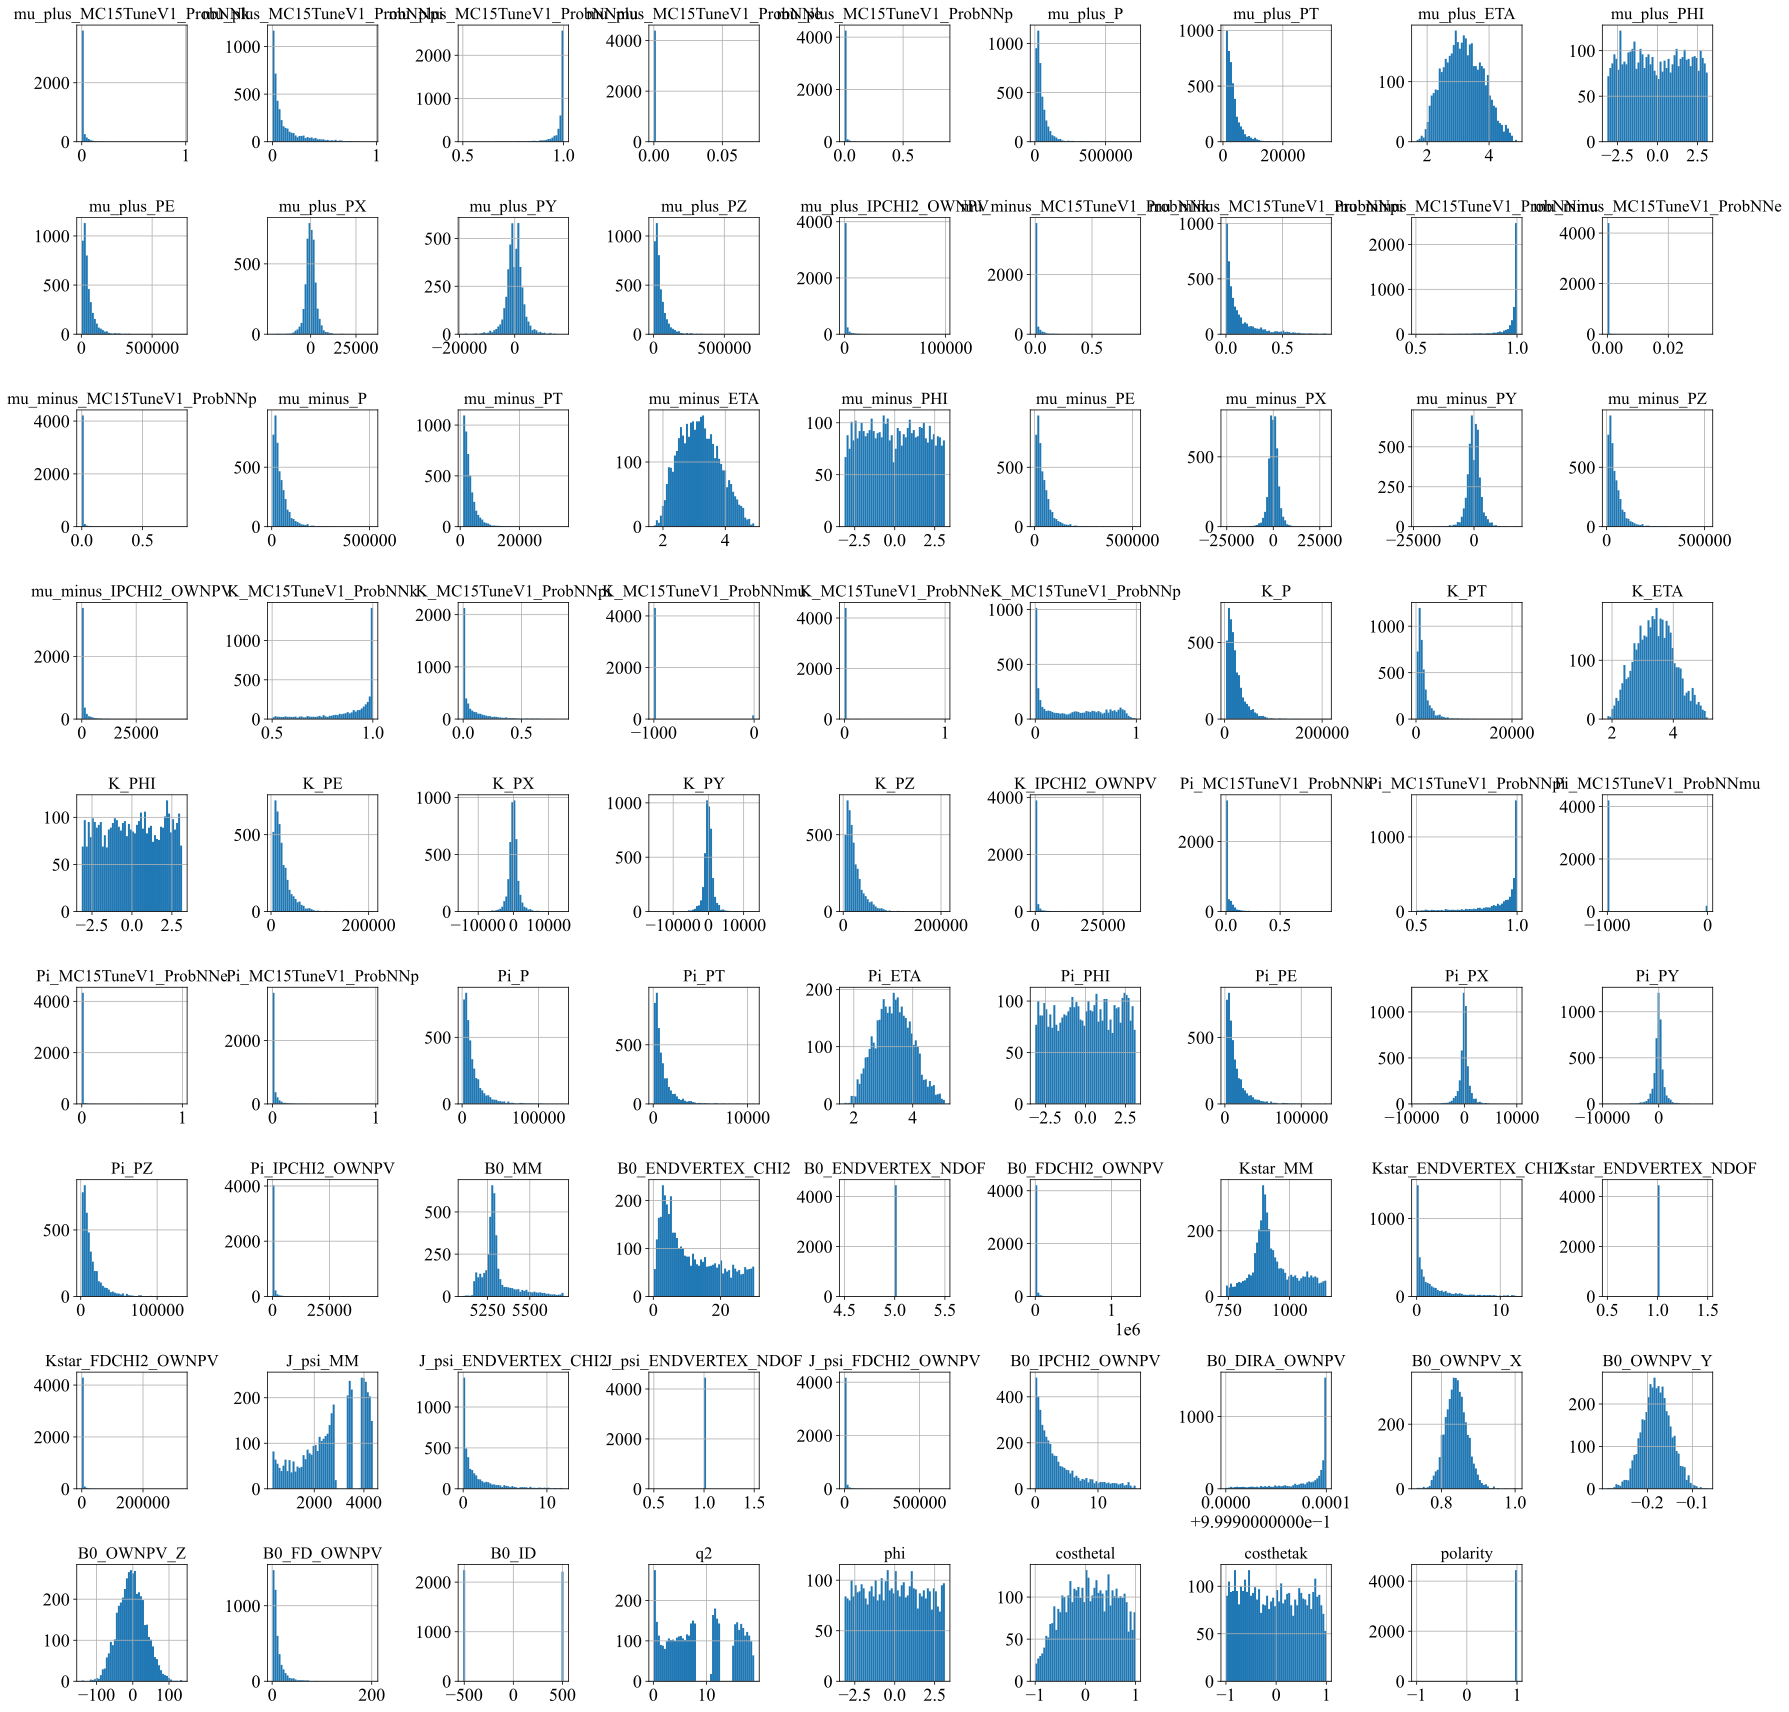

In [130]:
plt.rcParams["figure.figsize"] = (24,24)
plt.rc("figure", dpi=300)
filtered.hist(bins=50)
plt.tight_layout()
plt.show()

# 5. Send to Fitting Group

In [131]:
pickle.dump(filtered, open('outputs/0222_forest_total.pkl', 'wb'))
pickle.dump(acc_filtered, open('outputs/0222_forest_acc.pkl', 'wb'))